In [1]:
import datetime as dt

import matplotlib.pyplot as plt

import pydotplus

from IPython.display import Image

from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz

In [2]:
store -r

# Classification

In [3]:
# Relative monetary
relative = df.groupby(by='CustomerID', as_index=False).BasketDate.agg(['min', 'max'])

last = df['BasketDate'].max() + dt.timedelta(days=1)

relative['Days'] = relative['min'].apply(lambda x: (last - x).days)

relative = recency.merge(relative.merge(monetary.merge(frequency, on='CustomerID'), on='CustomerID'), on='CustomerID')

relative['Delta'] = (relative['max'] - relative['min']).dt.days + 1
relative['R_Monetary'] = relative['Monetary'] / relative['Delta']
relative['R_Frequency'] = relative['Frequency'] / relative['Delta']

del relative['Monetary']
del relative['Days']
del relative['Delta']
del relative['max']
del relative['min']

In [4]:
customer_profile = relative.copy()
customer_profile.head()

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0,12346.0,326,1,77183.600000,1.000000
1,12347.0,2,7,11.775956,0.019126
2,12348.0,75,4,5.078587,0.014134
3,12349.0,19,1,1457.550000,1.000000
4,12350.0,310,1,294.400000,1.000000


<AxesSubplot:>

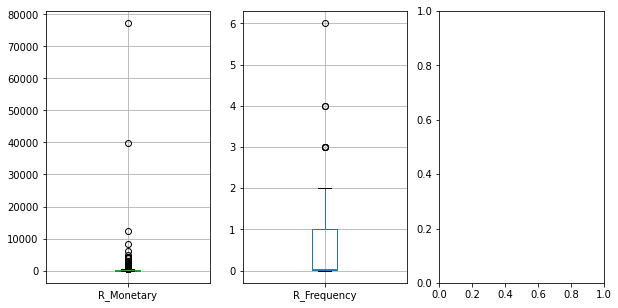

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
customer_profile.boxplot('R_Monetary', ax=ax[0])
customer_profile.boxplot('R_Frequency', ax=ax[1])

In [6]:
customer_profile.describe()

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,90.825104,4.245962,154.726250,0.363940
std,1721.994109,99.479900,7.634989,1366.773747,0.495490
min,12346.000000,1.000000,1.000000,0.111125,0.002762
25%,13812.250000,17.000000,1.000000,5.634888,0.019433
50%,15297.500000,50.000000,2.000000,15.296317,0.042553
75%,16778.750000,140.000000,5.000000,145.842500,1.000000
max,18287.000000,374.000000,206.000000,77183.600000,6.000000


In [7]:
ranges_m = [0.4, 0.85]
quantiles_m = customer_profile.quantile(q=ranges_m)
quantiles_m

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0.40,14705.6,31.0,2.0,10.092559,0.029412
0.85,17394.1,216.0,7.0,270.805000,1.000000


In [8]:
ranges_f = [0.3, 0.7]
quantiles_f = customer_profile.quantile(q=ranges_f)
quantiles_f

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0.3,14109.9,21.0,1.0,6.802132,0.022059
0.7,16480.2,107.0,4.0,101.205000,1.000000


In [9]:
ranges_r = [0.3, 0.66]
quantiles_r = customer_profile.quantile(q=ranges_r)
quantiles_r

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency
0.30,14109.90,21.0,1.0,6.802132,0.022059
0.66,16241.78,86.0,4.0,60.634080,0.200000


In [10]:
def ScoreM(x, data, thresh):
    if x <= thresh[data][ranges_m[0]]:
        return 1
    elif x <= thresh[data][ranges_m[1]]:
        return 2
    else:
        return 3

def ScoreF(x, data, thresh):
    if x <= thresh[data][ranges_f[0]]:
        return 1
    elif x <= thresh[data][ranges_f[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh):
    if x <= thresh[data][ranges_r[0]]:
        return 3
    elif x <= thresh[data][ranges_r[1]]:
        return 2
    else:
        return 1

In [11]:
customer_profile['MScore'] = customer_profile['R_Monetary'].apply(ScoreM, args=('R_Monetary', quantiles_m))
customer_profile['FScore'] = customer_profile['R_Frequency'].apply(ScoreF, args=('R_Frequency', quantiles_f))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r))
customer_profile['Score'] = (0.5 * customer_profile['MScore']
                            + 0 * customer_profile['FScore']
                            + 0.25 * customer_profile['RScore'])
customer_profile.describe()

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency,MScore,FScore,RScore,Score
count,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000,4334.000000
mean,15299.251731,90.825104,4.245962,154.726250,0.363940,1.749885,1.712275,1.962160,1.365482
std,1721.994109,99.479900,7.634989,1366.773747,0.495490,0.698301,0.480453,0.798943,0.362880
min,12346.000000,1.000000,1.000000,0.111125,0.002762,1.000000,1.000000,1.000000,0.750000
25%,13812.250000,17.000000,1.000000,5.634888,0.019433,1.000000,1.000000,1.000000,1.000000
50%,15297.500000,50.000000,2.000000,15.296317,0.042553,2.000000,2.000000,2.000000,1.250000
75%,16778.750000,140.000000,5.000000,145.842500,1.000000,2.000000,2.000000,3.000000,1.750000
max,18287.000000,374.000000,206.000000,77183.600000,6.000000,3.000000,3.000000,3.000000,2.250000


In [12]:
ranges = [0.25, 0.8]
quantiles = customer_profile.quantile(q=ranges)
quantiles

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency,MScore,FScore,RScore,Score
0.25,13812.25,17.0,1.0,5.634888,0.019433,1.0,1.0,1.0,1.00
0.80,17080.40,176.0,5.0,193.684000,1.000000,2.0,2.0,3.0,1.75


In [13]:
def Score(x, data, thresh):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [14]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles))
customer_labeled.head()

labels = customer_labeled.groupby('Label').CustomerID.unique()
# Sort the over-represented class to the head.
"""labels = labels[labels.apply(len).sort_values(ascending=False).index]
excess = len(labels.iloc[0]) - len(labels.iloc[1])
remove = np.random.choice(labels.iloc[0], excess, replace=False)
df2 = customer_labeled[~customer_labeled.CustomerID.isin(remove)]
customer_labeled = df2
df2"""

customer_labeled

,CustomerID,Recency,Frequency,R_Monetary,R_Frequency,MScore,FScore,RScore,Score,Label
0,12346.0,326,1,77183.600000,1.000000,3,2,1,1.75,Medium
1,12347.0,2,7,11.775956,0.019126,2,1,3,1.75,Medium
2,12348.0,75,4,5.078587,0.014134,1,1,2,1.00,Low
3,12349.0,19,1,1457.550000,1.000000,3,2,3,2.25,High
4,12350.0,310,1,294.400000,1.000000,3,2,1,1.75,Medium
...,...,...,...,...,...,...,...,...,...,...
4329,18280.0,278,1,180.600000,1.000000,2,2,1,1.25,Medium
4330,18281.0,181,1,80.820000,1.000000,2,2,1,1.25,Medium
4331,18282.0,8,2,1.496218,0.016807,1,1,3,1.25,Medium
4332,18283.0,4,16,6.254281,0.047904,1,2,3,1.25,Medium


In [15]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [16]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore 
customer_labeled.drop(columns=['CustomerID', 'Label', 'RScore', 'R_Monetary', 'FScore', 'MScore', 'Score', 'Frequency'], axis=1,inplace=True)

label = customer_labeled.pop('Label_num')

scaler = StandardScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(customer_labeled, label, stratify=label, test_size=0.3)
#train_set.head()

In [17]:
train_label.head()

681     2
2537    2
3213    2
50      1
3163    1
Name: Label_num, dtype: int64

## Decision Tree

In [18]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=4,
                                  min_samples_split=3, min_samples_leaf=10)

dec_t = dec_t.fit(train_set, train_label)

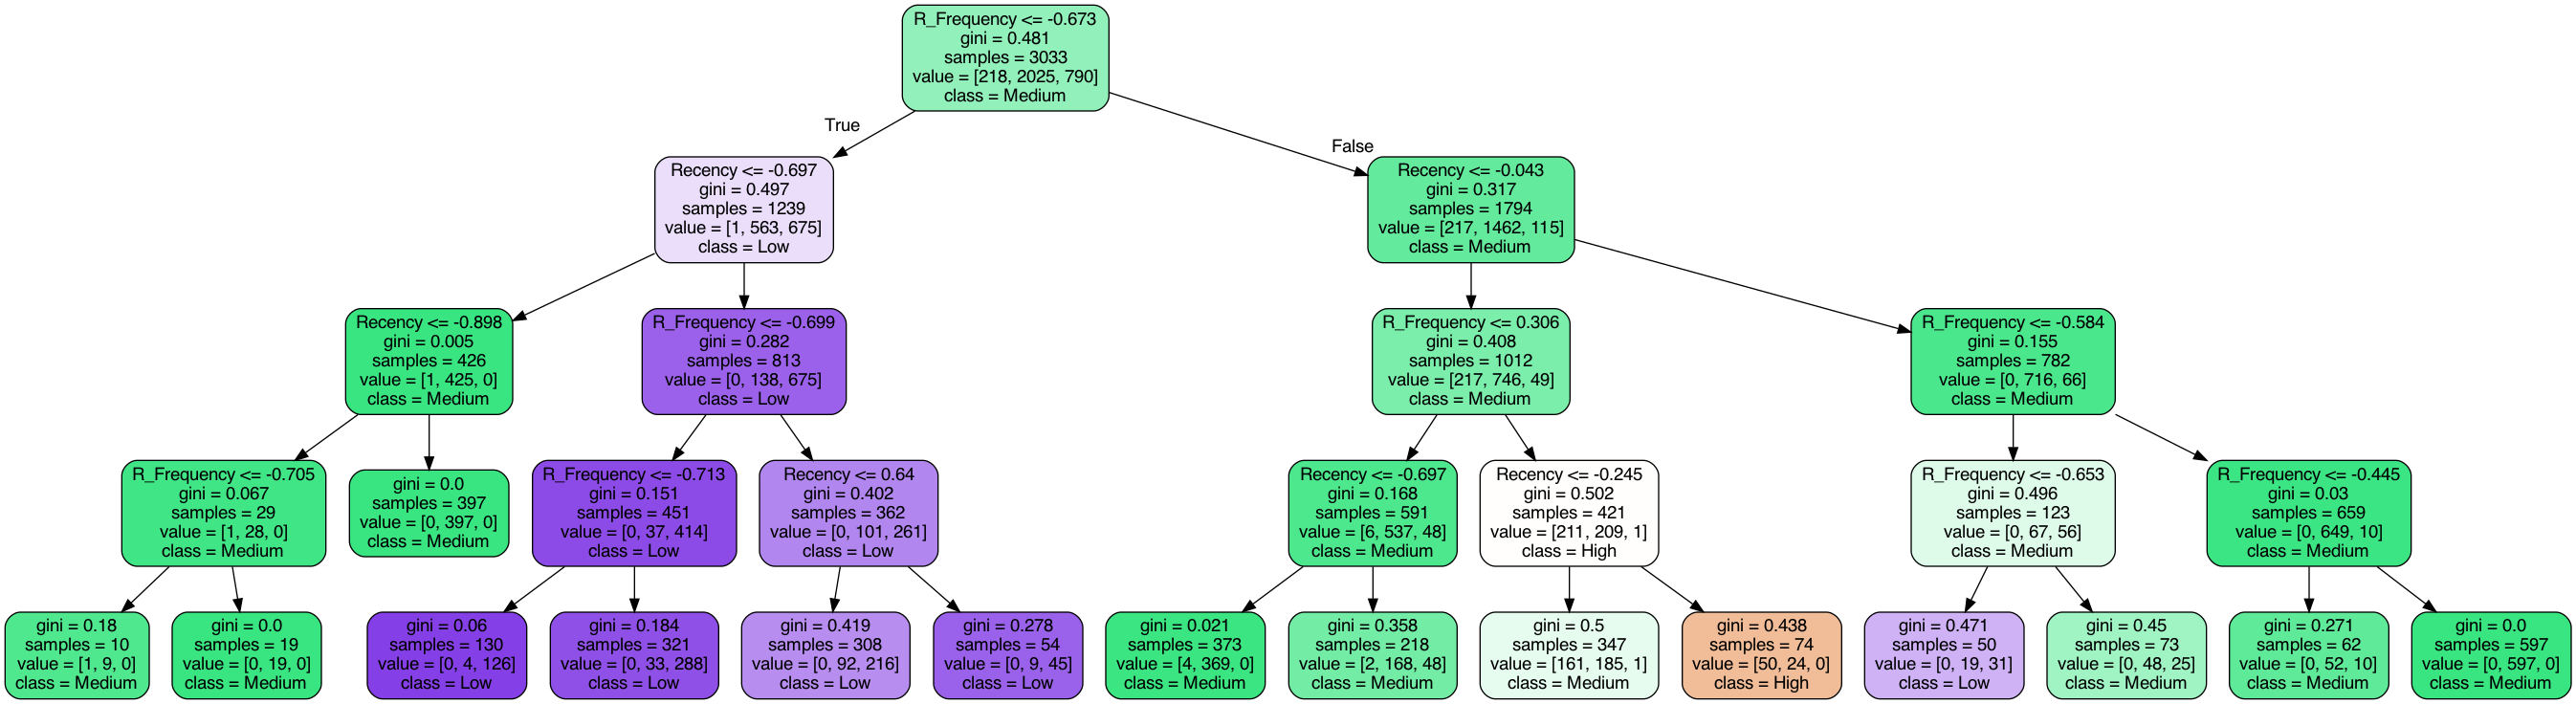

In [19]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Recency', 'R_Frequency'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [20]:
# Predict phase

train_pred_dt = dec_t.predict(train_set)
test_pred_dt = dec_t.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [21]:
# Evaulate the accuracy on the train set and the test set

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.8572370590174745
Accuracy test set  0.865488086087625
Precision train set  0.8490319729603562
Recall train set  0.8572370590174745
F1 score train set  0.8446123020437916
Support train set  (array([0.67567568, 0.87977099, 0.81807648]), array([0.2293578 , 0.91061728, 0.89367089]), array([0.34246575, 0.89492842, 0.85420448]), array([ 218, 2025,  790]))


In [22]:
# metrics computed on the test set
from sklearn.metrics import classification_report
print(classification_report(test_label, 
                            test_pred_dt, 
                            target_names=['High', 'Medium','Low']))

              precision    recall  f1-score   support

        High       0.67      0.19      0.30        94
      Medium       0.88      0.92      0.90       869
         Low       0.84      0.91      0.87       338

    accuracy                           0.87      1301
   macro avg       0.80      0.67      0.69      1301
weighted avg       0.86      0.87      0.85      1301



In [23]:
# cross validation
# the score array for test/train scores on each cv split
# the time for fitting/scoring the estimator on the train set for each cv split
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dec_t, train_set, train_label, cv=3, return_train_score=True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.004791657129923503
Score time  0.0009599526723225912
Test score  0.8440487965710518
Train score  0.8590504451038575


In [24]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[ 18,  76,   0],
       [  9, 800,  60],
       [  0,  30, 308]])

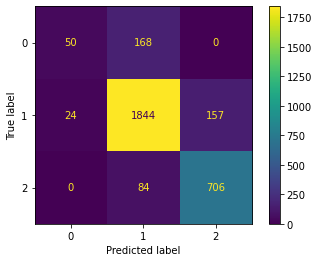

In [25]:
# it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(dec_t, train_set, train_label)
plt.show() 

## SVM

In [26]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC

svm = SVC(kernel='sigmoid', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='sigmoid')

In [27]:
#prediction on the test test
test_pred_proba_svm = svm.predict(test_set)

In [28]:
test_pred_svm = svm.predict(test_set)

In [29]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.16      0.09      0.11        94
      Medium       0.80      0.87      0.83       869
         Low       0.75      0.68      0.72       338

    accuracy                           0.76      1301
   macro avg       0.57      0.54      0.55      1301
weighted avg       0.74      0.76      0.75      1301



## KNN

In [30]:
## KNN

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [31]:
#prediction on the test test
test_pred_knn = knn.predict(test_set)

#compute the performance of the model

print(classification_report(test_label, 
                            test_pred_knn, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.55      0.79      0.65        94
      Medium       0.89      0.87      0.88       869
         Low       0.83      0.78      0.80       338

    accuracy                           0.84      1301
   macro avg       0.76      0.81      0.78      1301
weighted avg       0.85      0.84      0.84      1301

